<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>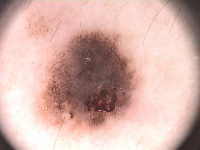</td><td>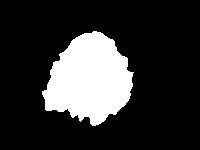</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [2]:
# !gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [3]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = '../data/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

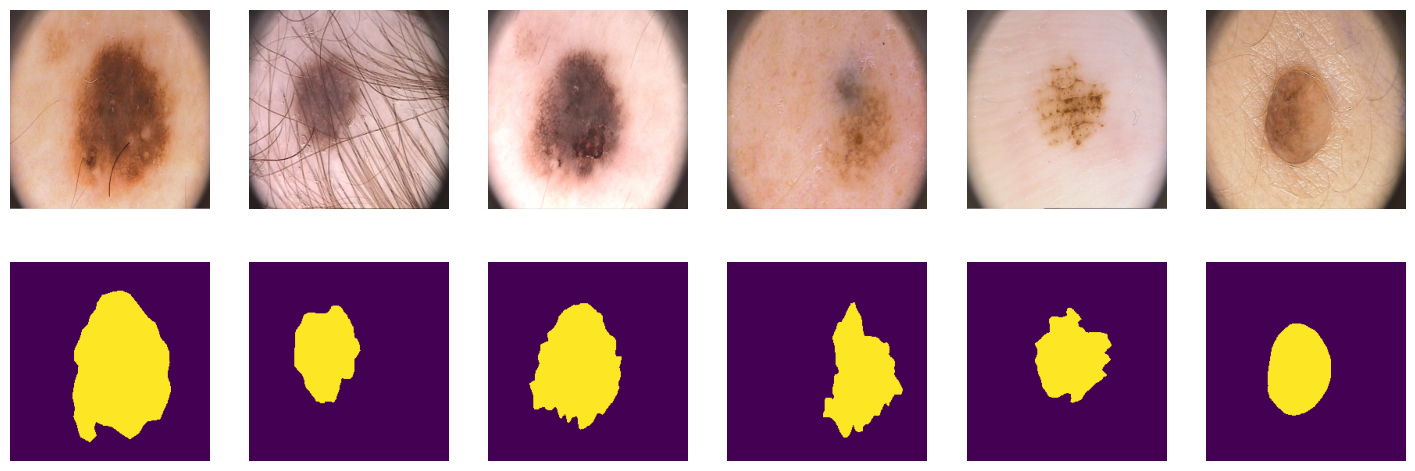

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def bce_loss(y_pred, y_real):
    # L = ŷ - y * ŷ + log(1 + exp(-ŷ))
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.sum()

def bce_true(y_pred, y_real):
    # L = - Σ [ y * log σ(ŷ) + (1 - y) * log(1 - σ(ŷ)) ]
    probs = torch.sigmoid(y_pred)
    probs = torch.clamp(probs, 1e-12, 1 - 1e-12)
    loss = -(y_real * torch.log(probs) + (1 - y_real) * torch.log(1 - probs))
    return loss.sum()

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 5.6285400390625
BCE loss честно посчитанный                = 5.6285400390625
BCE loss from torch bce_torch              = 5.6285400390625
BCE loss from torch with logits bce_torch  = 5.6285400390625


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 16.805513381958008
BCE loss честно посчитанный               = 16.805511474609375
BCE loss from torch bce_torch             = 16.805511474609375
BCE loss from torch with logits bce_torch = 16.805511474609375


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
# !gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

In [21]:
path_to_dummy_samples = '../data/PH2Dataset/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

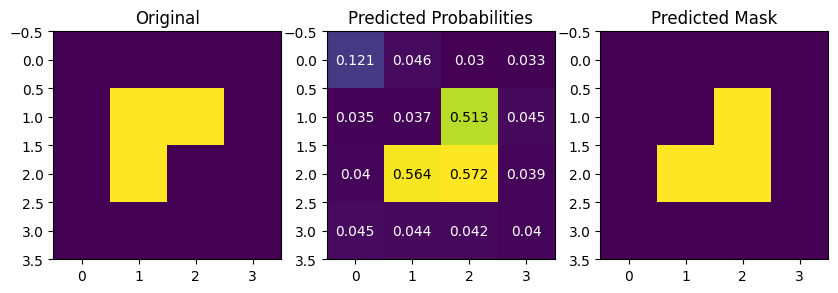

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## Шаг 4. Модель SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

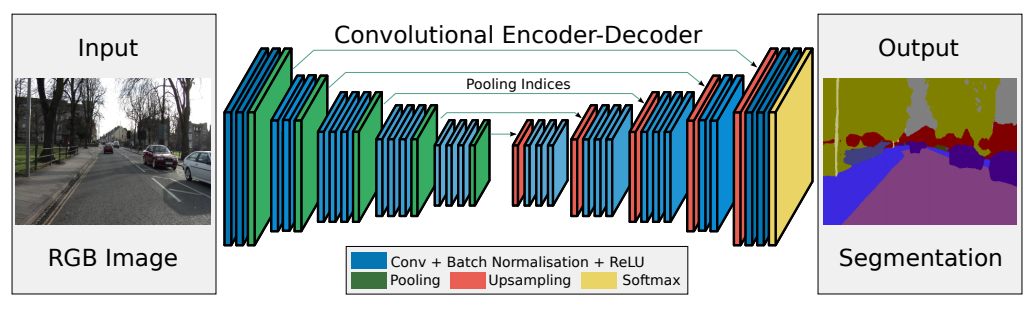

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [25]:
# model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

In [26]:
# model_vgg16

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [27]:
# Параметрами блока будут:
# - количество каналов на входе
# - количество каналов на выходе
# - глубина блока (2 или 3, по количеству конволюционных слоев)
# - kernel_size и padding
#
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        # первый conv меняет число каналов
        self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))
        # остальные conv оставляют ширину каналов
        for _ in range(depth - 1):
            self.layers.append(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))
        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    # возвращаем карту признаков после pool и индексы
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.maxpooling(x)
        return x, indices

По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [28]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size=3, padding=1, last_block=False):
        super(DecoderBlock, self).__init__()
        self.unpooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        self.last_block = last_block

        # первые (depth - 1) свертки не меняют число каналов
        for _ in range(depth - 1):
            self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, padding=padding))
            self.layers.append(nn.BatchNorm2d(in_channels))
            self.layers.append(nn.ReLU(inplace=True))

        # последняя свертка меняет число каналов
        self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
        if not self.last_block:
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

    def forward(self, x, indices):
        x = self.unpooling(x, indices)
        for layer in self.layers:
            x = layer(x)
        return x

Соединим блоки энкодера и декодера в модель SegNet:

In [29]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, num_features=64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2)
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2)
        self.encoder2 = EncoderBlock(num_features * 2, num_features * 4, depth=3)
        self.encoder3 = EncoderBlock(num_features * 4, num_features * 8, depth=3)

        # Bottleneck
        self.encoder4 = EncoderBlock(num_features * 8, num_features * 8, depth=3)

        # Decoder
        self.decoder4 = DecoderBlock(num_features * 8, num_features * 8, depth=3)
        self.decoder3 = DecoderBlock(num_features * 8, num_features * 4, depth=3)
        self.decoder2 = DecoderBlock(num_features * 4, num_features * 2, depth=3)
        self.decoder1 = DecoderBlock(num_features * 2, num_features, depth=2)
        self.decoder0 = DecoderBlock(num_features, out_channels, depth=2, last_block=True) # финальный, без BN и ReLU

    def forward(self, x):
        # encoder
        x, idx0 = self.encoder0(x)
        x, idx1 = self.encoder1(x)
        x, idx2 = self.encoder2(x)
        x, idx3 = self.encoder3(x)
        x, idx4 = self.encoder4(x)

        # decoder
        x = self.decoder4(x, idx4)
        x = self.decoder3(x, idx3)
        x = self.decoder2(x, idx2)
        x = self.decoder1(x, idx1)
        output = self.decoder0(x, idx0)

        return output  # без активации

## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [30]:
from tqdm.notebook import tqdm

In [31]:
def train_single_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch) # forward-pass

        loss.backward()  # backward-pass
        optimizer.step()  # update weights
        optimizer.zero_grad() # set parameter gradients to zero

        # calculate loss to show the user
        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, criterion, valid_dataloader, device, plot=False):

    iou_score = JaccardIndex(task="binary", threshold=0.5).to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          logits = model(X_batch)
          loss = criterion(logits, Y_batch)

          probs = torch.sigmoid(logits)
          iou = iou_score(probs, Y_batch)
          
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)

    if plot:
        clear_output(wait=True)

        fig, axes = plt.subplots(1, 3, figsize=(3*4, 3*4))

        orig_img = X_batch[0].permute(1,2,0).cpu().detach().numpy()
        orig_mask = Y_batch[0].squeeze().cpu().detach().numpy()
        pred_bin = (probs[0, 0] > 0.5).cpu().numpy()

        axes[0].imshow(orig_img);
        axes[0].set_title("Original Image")

        axes[1].imshow(orig_mask, interpolation='none')
        axes[1].set_title("Original Mask")

        axes[2].imshow(pred_bin)
        axes[2].set_title(f"iou = {float(avg_iou):.3f}")

        plt.show()

    return model, avg_loss, avg_iou

In [32]:
def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = False):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader, device)
        model, val_loss, val_iou = validate_single_epoch(model, criterion, valid_dataloader, device, plot=True)
        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())

        if plot_loss:
            fig, (ax1, ax2) = plt.subplots(1, 2)

            ax1.plot(list(range(len(total_train_loss))), total_train_loss, label = 'train loss')
            ax1.plot(list(range(len(total_val_loss))), total_val_loss, label = 'val loss')
            ax2.plot(list(range(len(total_val_iou))), total_val_iou, label='val iou')
            ax1.set_title("Loss")
            ax2.set_title("IoU")
            ax1.legend()
            plt.show()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_best_val_loss.pt')

        torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_val_iou.pt')

    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [33]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
epochs = 20
ckpt_path = '../models/PH2Dataset/SegNet_BCE'

In [34]:
# model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

Результаты SegNet с `BCEWithLogitsLoss` за 20 эпох

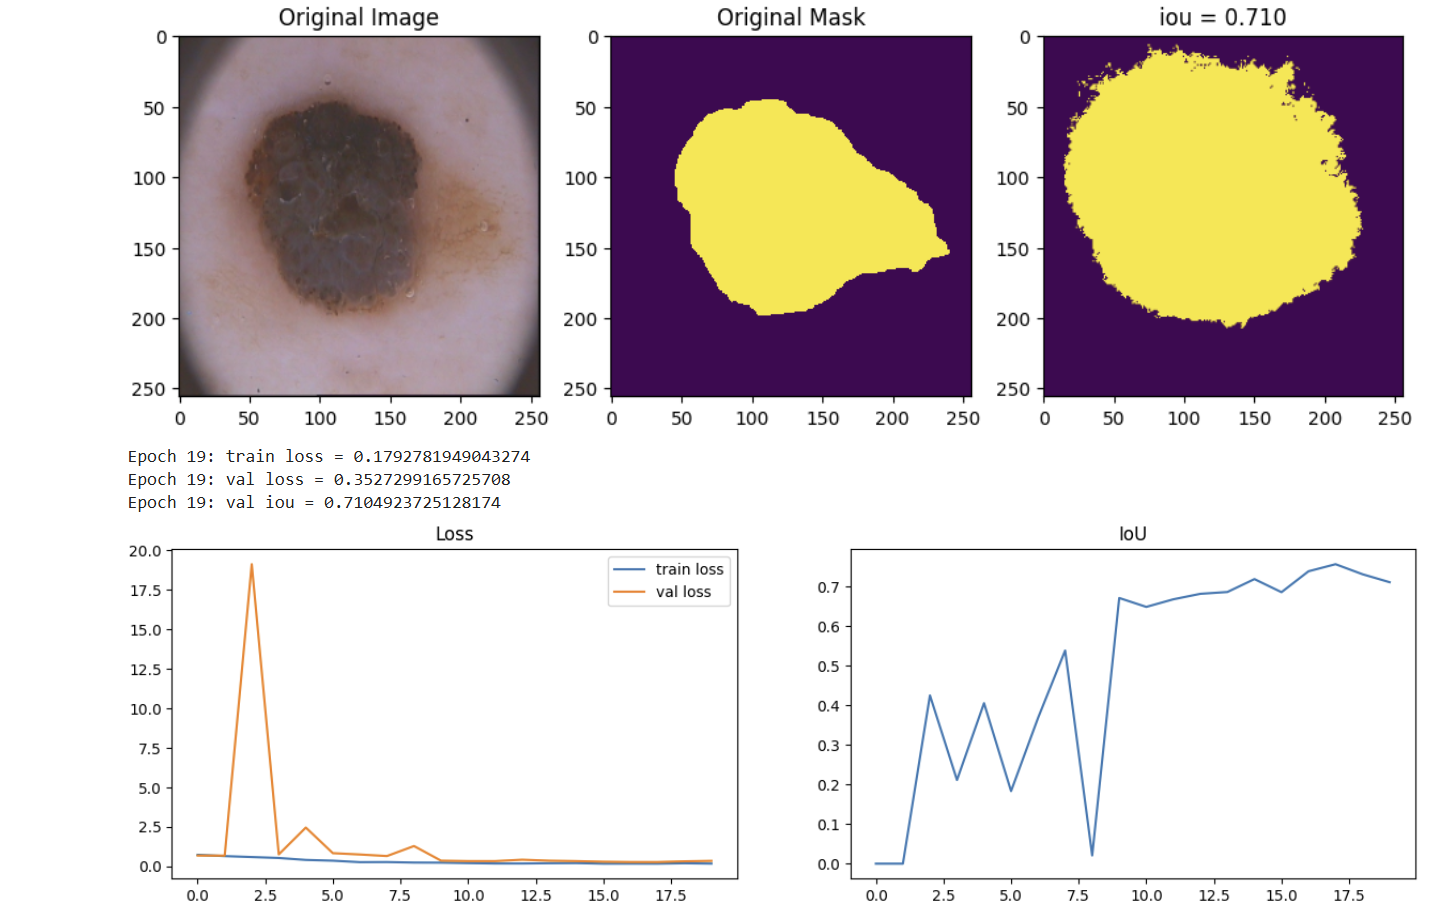

## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [35]:
def test(model, test_dataloader, device, ckpt_path, ckpt_name):

    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}', map_location=device))
    model.to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    
    
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(test_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch.to(device))
          avg_iou += iou_score(Y_pred, Y_batch)

    avg_iou = avg_iou/len(valid_dataloader)
    return avg_iou

In [36]:
model = SegNet().to(device)
ckpt_path = '../models/PH2Dataset/SegNet_BCE'
ckpt_name = 'epoch_17_best_val_loss.pt'

In [37]:
test(model, test_dataloader, device, ckpt_path, ckpt_name)

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.7264)

# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [38]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5, eps = 1e-8):
    '''
    Это именно метрика, не лосс.
    '''
    preds = (torch.sigmoid(logits) > threshold).float()
    TP = (preds * labels).sum()
    FP = (preds * (1 - labels)).sum()
    FN = ((1 - preds) * labels).sum()
    score = (2*TP + eps) / (2*TP + FP + FN + eps)
    return score

Проверим на корректность функцию dice_score:

In [39]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'].to(int))

C:\Users\anngr\Code\mfti\DLS1\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


tensor(0.6667)

In [40]:
# '''
# если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

# from torchmetrics.classification import Dice

# dice = Dice(average='micro').to(device)

# '''

In [41]:
assert dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [42]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor, eps = 1e-8):

    '''
    Это лосс.
    '''
    preds = torch.sigmoid(logits)
    TP = (preds * labels).sum()
    FP = (preds * (1 - labels)).sum()
    FN = ((1 - preds) * labels).sum()
    dice = (2*TP + eps) / (2*TP + FP + FN + eps)
    loss = 1 - dice
    return loss

Проверка на корректность:

In [43]:
# проверьте, что у вас установлена библиотека
# !uv add segmentation-models-pytorch

In [44]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756)

In [45]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [46]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    probs = torch.sigmoid(y_pred)
    probs = torch.clamp(probs, eps, 1 - eps)

    # p_t = σ(ŷ) * y + (1 - σ(ŷ)) * (1 - y)
    pt = probs * y_real + (1 - probs) * (1 - y_real)

    # L_BCE = - [ y * log σ(ŷ) + (1 - y) * log(1 - σ(ŷ)) ]
    bce = -(y_real * torch.log(probs) + (1 - y_real) * torch.log(1 - probs))

    # L_focal = (1 - p_t)^gamma * L_BCE
    loss = ((1 - pt) ** gamma * bce).sum()

    return loss


Проверка корректности функции:

In [47]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161)

In [48]:
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

tensor(3.6161)

In [49]:
import math

assert math.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'), focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0), abs_tol=1e-6)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [50]:
# Tversky loss function for image segmentation using 3D fully convolutional deep networks
def tversky_loss(logits: torch.Tensor, labels: torch.Tensor, alpha: float = 0.5, beta: float = 0.5, eps: float = 1e-8):
    
    probs = torch.sigmoid(logits)

    TP = (probs * labels).sum()
    FP = (probs * (1 - labels)).sum()
    FN = ((1 - probs) * labels).sum()

    tversky = (TP + eps) / (TP + alpha * FP + beta * FN + eps)
    loss = 1 - tversky
    return loss

In [51]:
tversky_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [52]:
segnet_model = SegNet().to(device)
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
criterion = DiceLoss(mode='binary')
epochs = 20
ckpt_path = '../models/PH2Dataset/SegNet_Dice'

In [53]:
# segnet_model, statistics = train(segnet_model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

Результаты SegNet с `DiceLoss` за 20 эпох

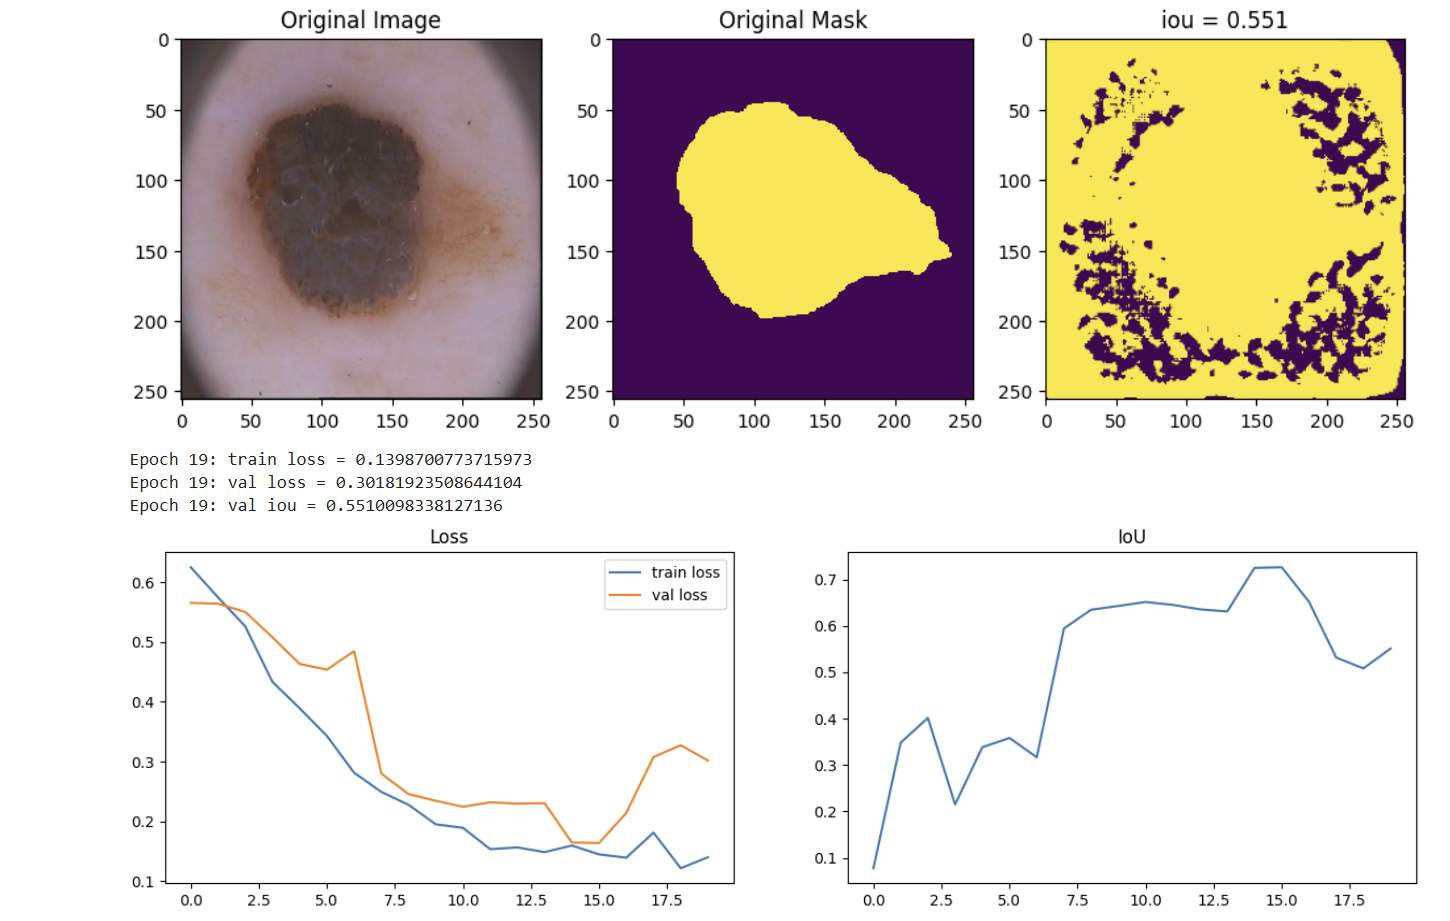

In [54]:
segnet_model = SegNet().to(device)
ckpt_path = '../models/PH2Dataset/SegNet_Dice'
ckpt_name = 'epoch_15_best_val_loss.pt'

In [55]:
test(segnet_model, test_dataloader, device, ckpt_path, ckpt_name)

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.6409)

In [56]:
def focal_criterion(logits, targets):
    if targets.ndim == logits.ndim - 1:
        targets = targets.unsqueeze(1)
    targets = targets.float()

    return sigmoid_focal_loss(
        logits,
        targets,
        alpha=-1,
        gamma=2,
        reduction='sum'
    )

In [57]:
segnet_model = SegNet().to(device)
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
criterion = focal_criterion
epochs = 20
ckpt_path = '../models/PH2Dataset/SegNet_Focal'

In [58]:
# segnet_model, statistics = train(segnet_model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

Результаты SegNet с `FocalLoss` за 20 эпох

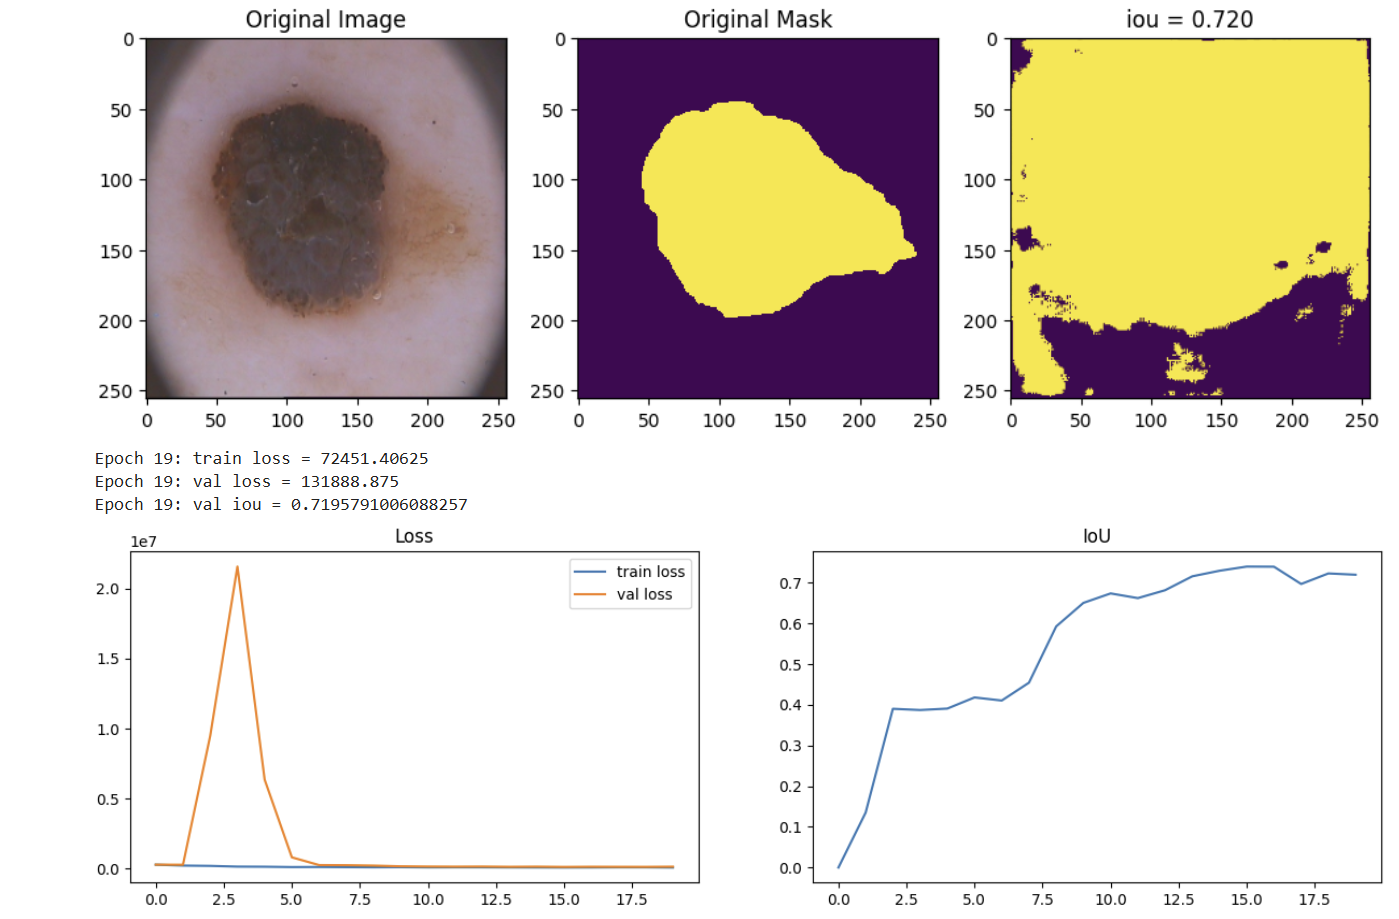

In [59]:
segnet_model = SegNet().to(device)
ckpt_path = '../models/PH2Dataset/SegNet_Focal'
ckpt_name = 'epoch_15_best_val_loss.pt'

In [60]:
test(segnet_model, test_dataloader, device, ckpt_path, ckpt_name)

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.7233)

# Задание: Новая модель!

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

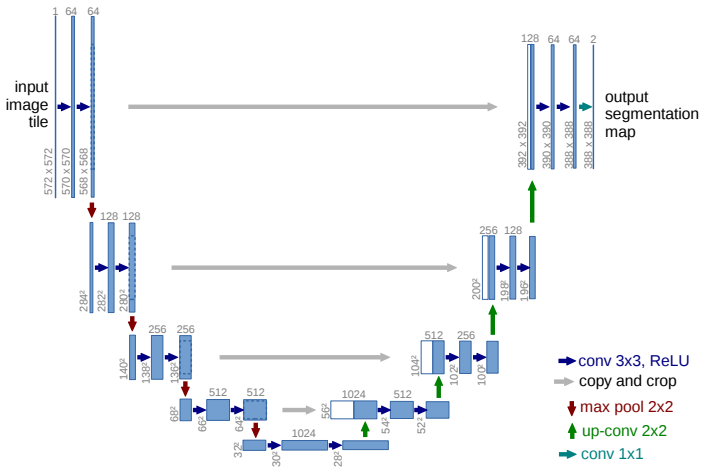

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [61]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

In [62]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()
        # encoder
        self.conv00 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn00 = nn.BatchNorm2d(64)
        self.conv01 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn01 = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(2)

        self.conv10 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(128)
        self.conv11 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2)

        self.conv20 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn20 = nn.BatchNorm2d(256)
        self.conv21 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn21 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2)

        self.conv30 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn30 = nn.BatchNorm2d(512)
        self.conv31 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn31 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.conv40 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn40 = nn.BatchNorm2d(1024)
        self.conv41 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn41 = nn.BatchNorm2d(1024)

        # decoder
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec30 = nn.Conv2d(1024, 512, 3, padding=1)
        self.bn_d30 = nn.BatchNorm2d(512)
        self.dec31 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn_d31 = nn.BatchNorm2d(512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec20 = nn.Conv2d(512, 256, 3, padding=1)
        self.bn_d20 = nn.BatchNorm2d(256)
        self.dec21 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn_d21 = nn.BatchNorm2d(256)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec10 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn_d10 = nn.BatchNorm2d(128)
        self.dec11 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_d11 = nn.BatchNorm2d(128)

        self.up0 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec00 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn_d00 = nn.BatchNorm2d(64)
        self.dec01 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_d01 = nn.BatchNorm2d(64)

        self.outc = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        # encoder
        x0 = F.relu(self.bn01(self.conv01(F.relu(self.bn00(self.conv00(x)))))) # 64, 256x256
        p0 = self.pool0(x0) # 64, 128x128

        x1 = F.relu(self.bn11(self.conv11(F.relu(self.bn10(self.conv10(p0)))))) # 128, 128x128
        p1 = self.pool1(x1) # 128, 64x64

        x2 = F.relu(self.bn21(self.conv21(F.relu(self.bn20(self.conv20(p1)))))) # 256, 64x64
        p2 = self.pool2(x2) # 256, 32x32

        x3 = F.relu(self.bn31(self.conv31(F.relu(self.bn30(self.conv30(p2)))))) # 512, 32x32
        p3 = self.pool3(x3) # 512, 16x16

        # bottleneck
        b = F.relu(self.bn41(self.conv41(F.relu(self.bn40(self.conv40(p3)))))) # 1024, 16x16

        # decoder
        u3 = self.up3(b) # 512, 32x32
        u3 = torch.cat([x3, u3], dim=1) # 1024, 32x32
        u3 = F.relu(self.bn_d31(self.dec31(F.relu(self.bn_d30(self.dec30(u3)))))) # 512, 32x32

        u2 = self.up2(u3) # 256, 64x64
        u2 = torch.cat([x2, u2], dim=1) # 512, 64x64
        u2 = F.relu(self.bn_d21(self.dec21(F.relu(self.bn_d20(self.dec20(u2)))))) # 256, 64x64

        u1 = self.up1(u2) # 128, 128x128
        u1 = torch.cat([x1, u1], dim=1) # 256, 128x128
        u1 = F.relu(self.bn_d11(self.dec11(F.relu(self.bn_d10(self.dec10(u1)))))) # 128, 128x128

        u0 = self.up0(u1) # 64, 256x256
        u0 = torch.cat([x0, u0], dim=1) # 128, 256x256
        u0 = F.relu(self.bn_d01(self.dec01(F.relu(self.bn_d00(self.dec00(u0)))))) # 64, 256x256

        output = self.outc(u0) # B, n_class, 256, 256
        return output

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [63]:
unet_model = UNet().to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
epochs = 20
ckpt_path = '../models/PH2Dataset/UNet_BCE'

In [64]:
# unet_model, statistics = train(unet_model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

Результаты UNet с `BCEWithLogitsLoss` за 20 эпох

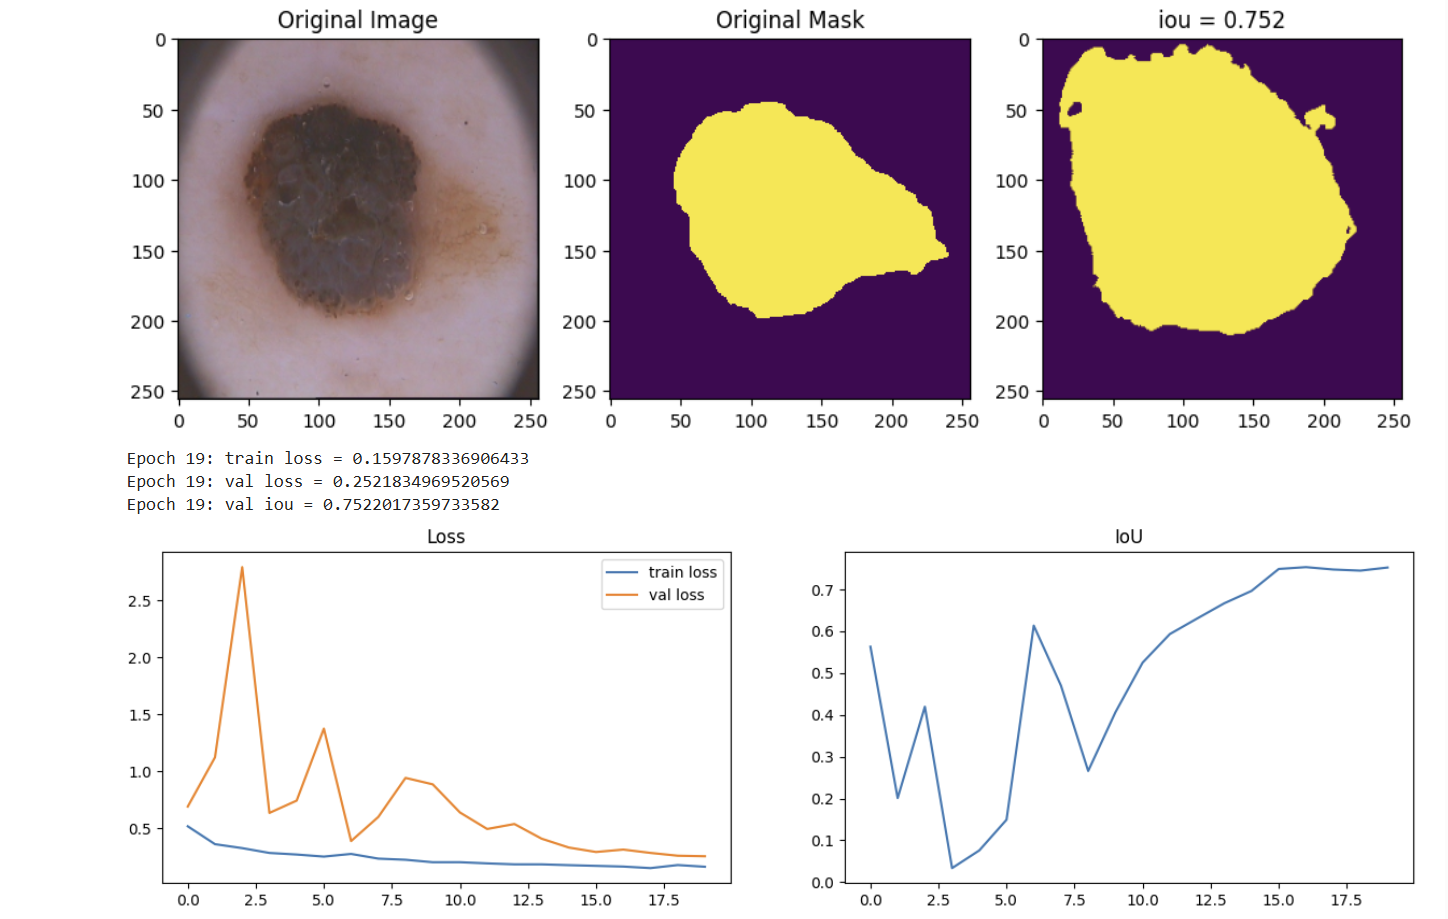

In [65]:
unet_model = UNet().to(device)
ckpt_path = '../models/PH2Dataset/UNet_BCE'
ckpt_name = 'epoch_19_best_val_loss.pt'

In [66]:
test(unet_model, test_dataloader, device, ckpt_path, ckpt_name)

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.7478)

In [67]:
unet_model = UNet().to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
criterion = DiceLoss(mode='binary')
epochs = 20
ckpt_path = '../models/PH2Dataset/UNet_Dice'

In [68]:
# segnet_model, statistics = train(unet_model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

Результаты UNet с `DiceLoss` за 20 эпох

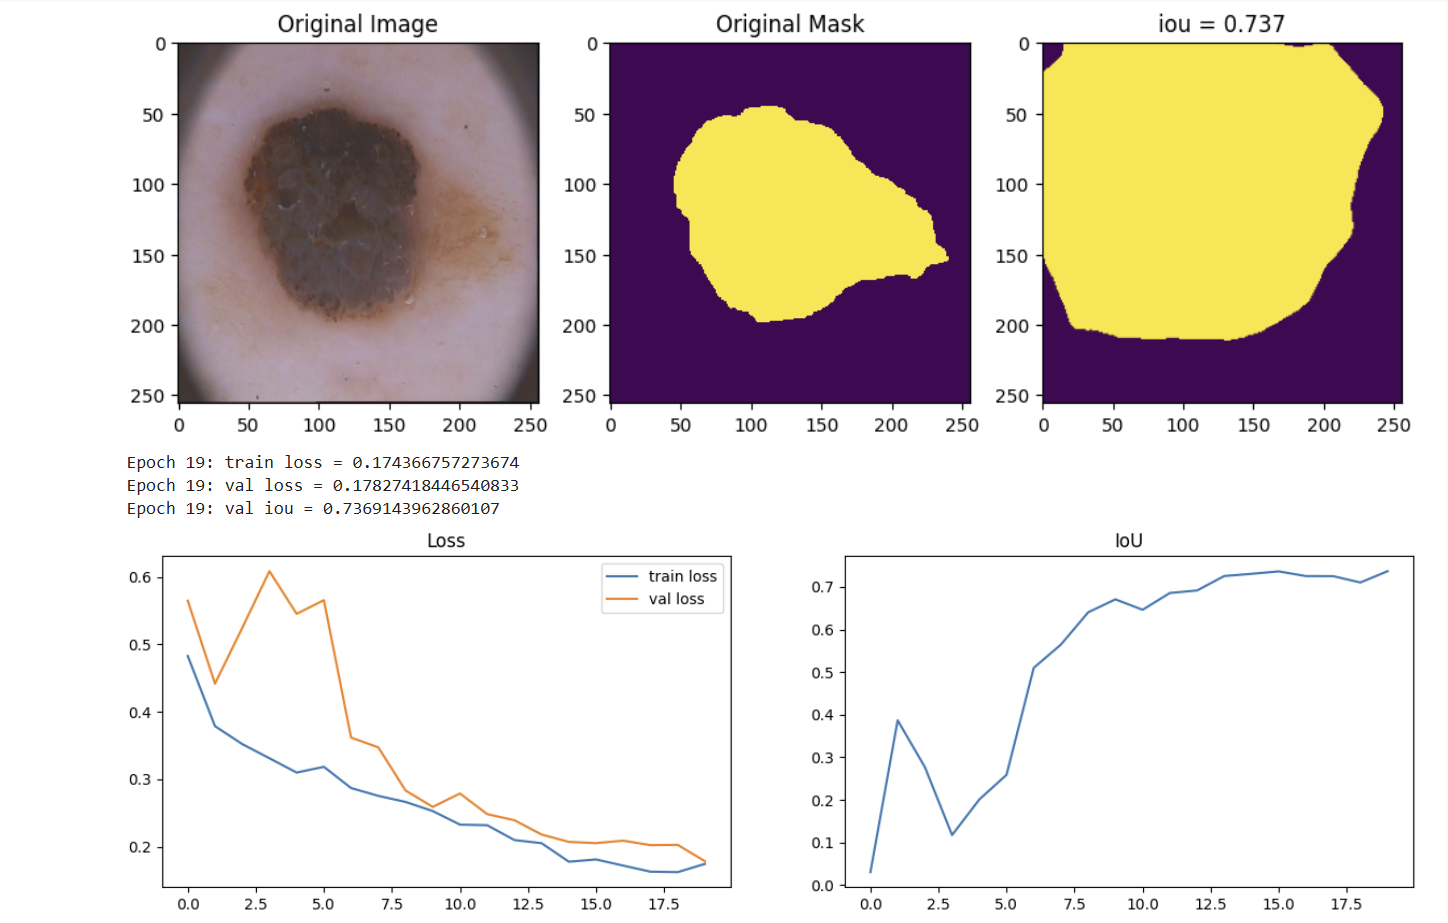

In [69]:
unet_model = UNet().to(device)
ckpt_path = '../models/PH2Dataset/UNet_Dice'
ckpt_name = 'epoch_19_best_val_loss.pt'

In [70]:
test(unet_model, test_dataloader, device, ckpt_path, ckpt_name)

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.7008)

In [71]:
unet_model = UNet().to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
criterion = focal_criterion
epochs = 20
ckpt_path = '../models/PH2Dataset/UNet_Focal'

In [72]:
# unet_model, statistics = train(unet_model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

Результаты UNet с `FocalLoss` за 20 эпох

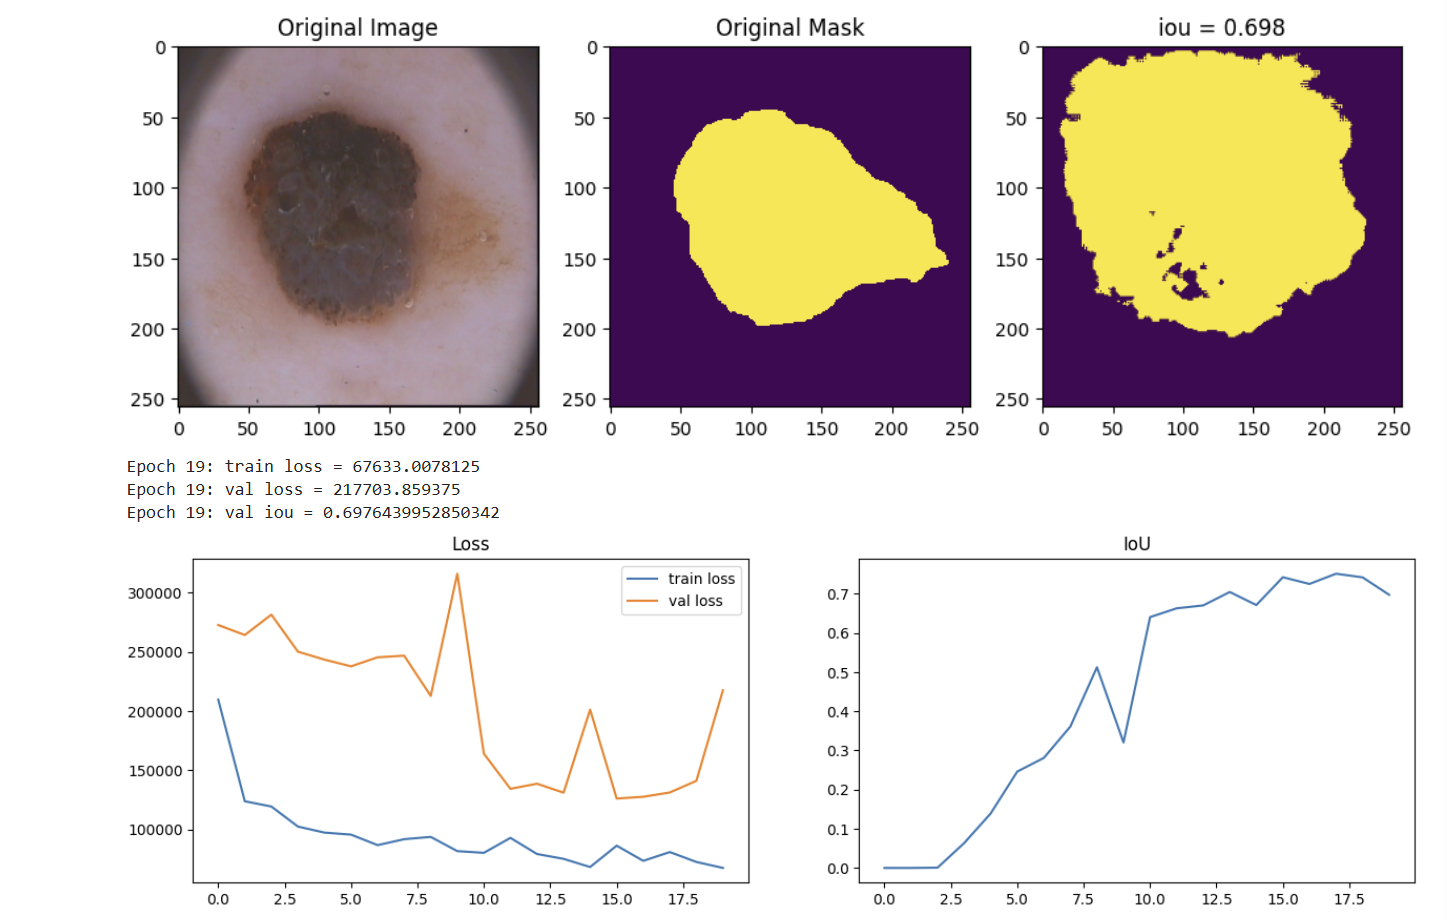

In [73]:
unet_model = UNet().to(device)
ckpt_path = '../models/PH2Dataset/UNet_Focal'
ckpt_name = 'epoch_15_best_val_loss.pt'

In [74]:
test(unet_model, test_dataloader, device, ckpt_path, ckpt_name)

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.7310)

**Ответы**

1. По метрике лидер - UNet с BCEWithLogitsLoss, сразу за ним UNet с DiceLoss. SegNet дает ниже IoU при любых лоссах.

2. По лоссам, если смотреть именно на графики: лучше всего UNet с DiceLoss - train и val плавно падают и близко друг к другу. Потом UNet с BCE - сначала пик, дальше стабильное снижение. У SegNet лоссы дергаются, у Dice на SegNet к концу видно переобучение. Focal у обеих моделей шумный и в другом масштабе, по кривым ему меньше доверия.

3. По времени на эпоху быстрее SegNet, он проще. По скорости выхода на хорошее качество выгоднее UNet, он за те же 20 эпох набирает выше IoU.

4. Визуально SegNet то раздувает маску, то оставляет много мусора по краям и дырок внутри. UNet выдает аккуратный контур, меньше шума, маска больше похожа на настоящую разметку.
